In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

df = pd.read_csv("./data/weatherkit_plus_load.csv", parse_dates=['event_timestamp'])

# Keep only necessary columns
df = df[['weatherkit_forecast_cloud_cover_pc', 'load_MW']].dropna()

print(df['weatherkit_forecast_cloud_cover_pc'].describe())


count    14298.000000
mean        32.690287
std         29.219298
min          0.000000
25%         10.000000
50%         24.000000
75%         48.000000
max         99.000000
Name: weatherkit_forecast_cloud_cover_pc, dtype: float64


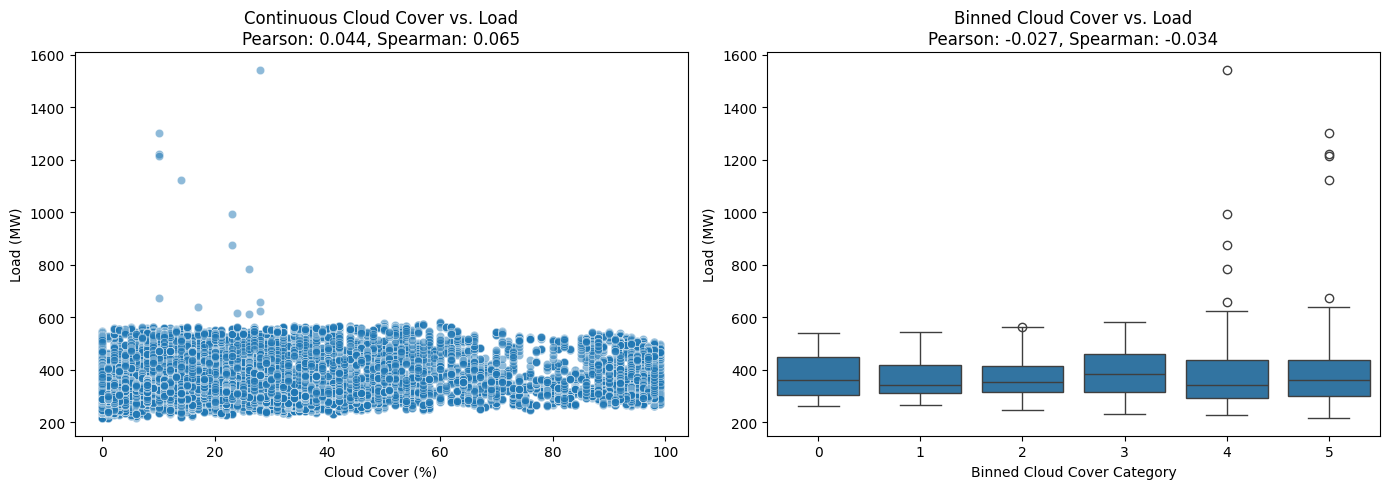

{'Continuous Pearson Correlation': np.float64(0.044069285237105654),
 'Continuous Spearman Correlation': np.float64(0.0653225238327648),
 'Binned Pearson Correlation': np.float64(-0.027367767949467686),
 'Binned Spearman Correlation': np.float64(-0.03435977648873131)}

In [45]:

# Compute correlation when cloud cover is continuous
pearson_corr_continuous, _ = pearsonr(df['weatherkit_forecast_cloud_cover_pc'], df['load_MW'])
spearman_corr_continuous, _ = spearmanr(df['weatherkit_forecast_cloud_cover_pc'], df['load_MW'])

# Arbitrarily select 6 bins
df['cloud_cover_category'] = pd.cut(df['weatherkit_forecast_cloud_cover_pc'],
                                    bins=[0, 20, 40, 60, 80,90, 100],
                                    labels=[5, 4, 3, 2, 1, 0],
                                    include_lowest=True).astype(int)

# Compute correlation when cloud cover is binned
pearson_corr_binned, _ = pearsonr(df['cloud_cover_category'], df['load_MW'])
spearman_corr_binned, _ = spearmanr(df['cloud_cover_category'], df['load_MW'])

# Plot relationships
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Continuous cloud cover vs. Load
sns.scatterplot(x=df['weatherkit_forecast_cloud_cover_pc'], y=df['load_MW'], alpha=0.5, ax=axes[0])
axes[0].set_title(f"Continuous Cloud Cover vs. Load\nPearson: {pearson_corr_continuous:.3f}, Spearman: {spearman_corr_continuous:.3f}")
axes[0].set_xlabel("Cloud Cover (%)")
axes[0].set_ylabel("Load (MW)")

# Binned cloud cover vs. Load
sns.boxplot(x=df['cloud_cover_category'], y=df['load_MW'], ax=axes[1])
axes[1].set_title(f"Binned Cloud Cover vs. Load\nPearson: {pearson_corr_binned:.3f}, Spearman: {spearman_corr_binned:.3f}")
axes[1].set_xlabel("Binned Cloud Cover Category")
axes[1].set_ylabel("Load (MW)")

plt.tight_layout()
plt.show()

# Return correlation values
{
    "Continuous Pearson Correlation": pearson_corr_continuous,
    "Continuous Spearman Correlation": spearman_corr_continuous,
    "Binned Pearson Correlation": pearson_corr_binned,
    "Binned Spearman Correlation": spearman_corr_binned
}

In [4]:
# Load dataset
file_path = "./data/weatherkit_plus_load.csv"  # Update with actual path
df = pd.read_csv(file_path, parse_dates=['event_timestamp'])

# Function to dynamically generate bins and interpretations based on a given number of bins
def create_dynamic_temperature_labels(df, num_labels):
    min_temp, max_temp = df["weatherkit_observed_temperature_C"].min(), df["weatherkit_observed_temperature_C"].max()
    comfort_min, comfort_max = 23, 26  # Fixed comfort zone

    # Ensure num_labels is at least 1 for meaningful division
    num_labels = max(1, num_labels)

    # Generate linearly spaced bins for heating (below 23°C) and cooling (above 26°C)
    bins_below = np.linspace(min_temp, comfort_min, num_labels, endpoint=False)
    bins_above = np.linspace(comfort_max, max_temp, num_labels, endpoint=True)

    # Combine bins ensuring comfort zone (23-26°C) is a single bin
    temp_bins = np.unique(np.concatenate([bins_below, [comfort_min, comfort_max], bins_above]))

    # Assign labels: 0 for comfort, increasing integers for heating & cooling symmetrically
    labels_below = list(range(-num_labels, 0))  # Negative labels for heating (shifted later)
    labels_above = list(range(1, num_labels + 1))  # Positive labels for cooling
    temp_labels = labels_below + [0] + labels_above

    # Ensure labels match `len(bins) - 1`
    temp_labels = temp_labels[: len(temp_bins) - 1]

    # Assign temperature categories
    df["temp_interpretation"] = pd.cut(df["weatherkit_observed_temperature_C"], bins=temp_bins, labels=temp_labels, include_lowest=True).astype(int)
    df["temp_interpretation"] = df["temp_interpretation"].abs()
    return df, temp_bins, temp_labels


In [5]:
# Function to create dynamic cloud cover bins with labels from 1 to max_bins
def create_dynamic_cloud_bins(df, max_bins):
    min_cloud, max_cloud = df["weatherkit_observed_cloud_cover_pc"].min(), df["weatherkit_observed_cloud_cover_pc"].max()

    # Generate equal bins for cloud cover
    cloud_bins = np.linspace(min_cloud, max_cloud, max_bins + 1)

    # Assign integer labels from 1 to max_bins
    cloud_labels = list(range(1, max_bins + 1))

    # Assign cloud categories
    df["cloud_interpretation"] = pd.cut(df["weatherkit_observed_cloud_cover_pc"], bins=cloud_bins, labels=cloud_labels, include_lowest=True).astype(int)

    return df, cloud_bins, cloud_labels


In [8]:
def compute_correlations(df, temp_labels_range, cloud_labels_range):
    results = []

    for temp_labels in temp_labels_range:
        for cloud_labels in cloud_labels_range:
            df_temp, temp_bins, temp_labels_list = create_dynamic_temperature_labels(df.copy(), temp_labels)

            # Generate dynamic cloud labels
            df_combined, cloud_bins, cloud_labels_list = create_dynamic_cloud_bins(df_temp, cloud_labels)

            # Combine temperature and cloud interpretation into a single feature
            df_combined["weather_combined"] = df_combined["temp_interpretation"].astype(str) + "_" + df_combined["cloud_interpretation"].astype(str)

            # Encode the combined feature numerically
            df_combined["weather_combined_encoded"] = df_combined["weather_combined"].astype("category").cat.codes

            # Compute Pearson and Spearman correlations with Load (MW)
            pearson_corr = df_combined["weather_combined_encoded"].corr(df_combined["load_MW"], method="pearson")
            spearman_corr = df_combined["weather_combined_encoded"].corr(df_combined["load_MW"], method="spearman")

            # Store results
            results.append({
                "Temp": temp_labels,
                "Cloud": cloud_labels,
                "Pearson Correlation": pearson_corr,
                "Spearman Correlation": spearman_corr,
                "Temp Labels": temp_labels_list,
                "Temp Bins": temp_bins,

            })

    return pd.DataFrame(results)

temp_labels_range = range(2, 15)
cloud_labels_range = range(2, 15)

correlation_results = compute_correlations(df, temp_labels_range, cloud_labels_range)

# Sort results by absolute correlation values
correlation_results["Pearson Correlation Abs"] = correlation_results["Pearson Correlation"].abs()
correlation_results["Spearman Correlation Abs"] = correlation_results["Spearman Correlation"].abs()
correlation_results_sorted = correlation_results.sort_values(
    by=["Spearman Correlation Abs", "Pearson Correlation Abs"], ascending=False
)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
print(correlation_results_sorted[['Temp', 'Cloud', 'Pearson Correlation Abs', 'Spearman Correlation Abs', 'Temp Bins']])

     Temp  Cloud  Pearson Correlation Abs  Spearman Correlation Abs  \
111    10      9                 0.655358                  0.676575   
110    10      8                 0.654848                  0.675996   
109    10      7                 0.654533                  0.675346   
108    10      6                 0.654325                  0.675131   
107    10      5                 0.653558                  0.674537   
105    10      3                 0.651409                  0.673611   
106    10      4                 0.652521                  0.673564   
124    11      9                 0.652873                  0.673494   
123    11      8                 0.652531                  0.672962   
122    11      7                 0.652191                  0.672396   
121    11      6                 0.651922                  0.672254   
98      9      9                 0.648298                  0.672029   
120    11      5                 0.651227                  0.671716   
104   